---
title: Callback
categories: deep-learning
date: 2020-11-09
---

本文将介绍Tensorflow中的Callback。它是一个非常有用的工具，用于自定义train，evaluate和predict中的行为。

## Callback的方法

实现Callback很简单，主要有两步：

- 创建一个新的类，这个类继承`tf.keras.callbacks.Callback`。

- 根据需求，重载`tf.keras.callbacks.Callback`中的如下方法。
  - `on_(train|test|predict)_begin(self, logs=None)`
  - `on_(train|test|predict)_end(self, logs=None)`
  - `on_(train|test|predict)_batch_begin(self, batch, logs=None)`
  - `on_(train|test|predict)_batch_end(self, batch, logs=None)`
  - `on_epoch_begin(self, epoch, logs=None)`
  - `on_epoch_end(self, epoch, logs=None)`

  以上所有`begin`结尾方法，其logs是一个空的list。而end结尾的方法，其logs大多是有内容的，详见后文。

完成了前两步准备后，在模型训练，评估或预测时，把Callback类传入，则上面的那些方法将会被调用。其调用的具体的规则如下。

- `tf.keras.Model.fit()`

  Callback中方法调用顺序的伪代码如下。

  ~~~python
  on_train_begin(self, logs=None)
  for epoch in epoches:
      on_epoch_begin(self, epoch, logs=None)
      for batch in train_batches:
          on_train_batch_begin(self, batch, logs=None)
          on_train_batch_end(self, batch, logs=None)     # logs.keys = [loss, ...]        
      on_test_begin(self, logs=None)
      for batch in test_batches:
          on_test_batch_begin(self, batch, logs=None)
          on_test_batch_end(self, batch, logs=None)     # logs.keys = [loss, ...]
      on_test_end(self, logs=None)    # logs.keys = [loss, ...]    
      on_epoch_end(self, epoch, logs=None)    # logs.keys = [loss, val_loss, ...]
  on_train_end(self, logs=None)    # logs.keys = [loss, val_loss, ...]
  ~~~

- `tf.keras.Model.evaluate()`

  Callback中方法调用顺序的伪代码如下。

  ~~~python
  on_test_begin(self, logs=None)
  for batch in test_batches:
      on_test_batch_begin(self, batch, logs=None)            
      on_test_batch_end(self, batch, logs=None)       # logs.keys = [loss, ...] 
  on_test_end(self, logs=None)    # logs.keys = [loss, val_loss, ...]
  ~~~

- `tf.keras.Model.predict()`

  Callback中方法调用顺序的伪代码如下。

  ~~~python
  on_predict_begin(self, logs=None)
  for batch in test_batches:
      on_predict_batch_begin(self, batch, logs=None)    
      on_predict_batch_end(self, batch, logs=None)    # logs = [outputs, ...] 
  on_predict_end(self, logs=None)
  ~~~

## Callback实践

### 调用顺序

下面的代码展示了Callback中方法的调用顺序。首先创建模型和加载数据。

In [149]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from pprint import pprint
from tensorflow import keras

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]
)

def get_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(10))    
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    return model

def get_mnist():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0
    return x_train, y_train, x_test, y_test


然后自定义Callback类。

In [70]:
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))        

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_test_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start testing; got log keys: {}".format(keys))

    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop testing; got log keys: {}".format(keys))

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start predicting; got log keys: {}".format(keys))

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop predicting; got log keys: {}".format(keys))

    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("    Training: start of batch {}; got log keys: {}".format(batch, keys))

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("    Training: end of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("    Evaluating: start of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("    Evaluating: end of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("    Predicting: start of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("    Predicting: end of batch {}; got log keys: {}".format(batch, keys))


下面来进行模型训练，评估和预测。

In [71]:
x_train, y_train, x_test, y_test = get_mnist()
x_train = x_train[:1024]
y_train = y_train[:1024]
x_test = x_test[:512]
y_test = y_test[:512]

model = get_model()
model.fit(
    x_train,
    y_train,
    batch_size=256,
    epochs=1,
    verbose=0,
    validation_split=0.5,
    callbacks=[CustomCallback()],
)

print('-'*100)
res = model.evaluate(
    x_test, y_test, batch_size=256, verbose=0, callbacks=[CustomCallback()]
)

print('-'*100)
res = model.predict(x_test, batch_size=256, callbacks=[CustomCallback()])

Starting training; got log keys: []
Start epoch 0 of training; got log keys: []
    Training: start of batch 0; got log keys: []
    Training: end of batch 0; got log keys: ['loss', 'accuracy']
    Training: start of batch 1; got log keys: []
    Training: end of batch 1; got log keys: ['loss', 'accuracy']
Start testing; got log keys: []
    Evaluating: start of batch 0; got log keys: []
    Evaluating: end of batch 0; got log keys: ['loss', 'accuracy']
    Evaluating: start of batch 1; got log keys: []
    Evaluating: end of batch 1; got log keys: ['loss', 'accuracy']
Stop testing; got log keys: ['loss', 'accuracy']
End epoch 0 of training; got log keys: ['loss', 'accuracy', 'val_loss', 'val_accuracy']
Stop training; got log keys: ['loss', 'accuracy', 'val_loss', 'val_accuracy']
----------------------------------------------------------------------------------------------------
Start testing; got log keys: []
    Evaluating: start of batch 0; got log keys: []
    Evaluating: end of ba

![image-20201108175730619](images/image-20201108175730619.png)

### Early Stopping

在模型训练时，为了减少过拟合，往往会采用Early Stopping的技术。它会比较某一个metrics（最常用的是`val_loss`）是否在持续在降低，如果连续几个epochs都没有降低，将会中止训练，而且往往会把参数恢复到之前metrics最低时候的参数。

下面自定义的类实现了Early Stopping的逻辑。下面代码中，当设置`self.model.stop_training = True`后，训练将会退出。

In [72]:
class MyEarlyStopping(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(MyEarlyStopping, self).__init__()
        self.patience = patience
        self.best_weights = None
        self.best_epoch = -1

    def on_train_begin(self, logs=None):
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        if np.less(current, self.best):
            self.best = current
            self.best_epoch = epoch
            self.wait = 0
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch {}.".format(self.best_epoch+1))
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))
            
model = get_model()
history = model.fit(
    x_train,
    y_train,
    batch_size=256,
    epochs=30,
    verbose=0,
    validation_split=0.5,
    callbacks=[MyEarlyStopping(patience=5)],    
)

Restoring model weights from the end of the best epoch 25.
Epoch 00030: early stopping


![image-20201109022827577](images/image-20201109022827577.png)

下面来显示训练过程中的val_loss趋势。

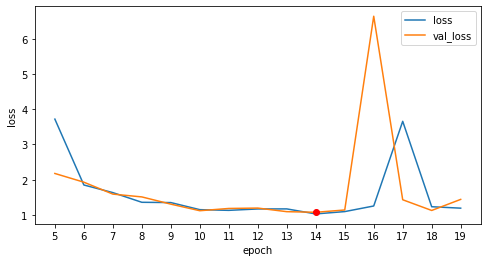

In [15]:
def plot_history(history, metrics_name='accuracy'):
    plt.figure(figsize=(8, 4))
    # 忽略前面几个epoch
    start_epoch = 5    
    metrics = history.history[metrics_name][start_epoch-1:]
    val_metrics = history.history['val_' + metrics_name][start_epoch-1:]
    epochs = [start_epoch + i for i in range(len(metrics))]
    lowest = np.argmin(val_metrics)
    
    plt.plot(epochs, metrics, label=metrics_name)
    plt.plot(epochs, val_metrics, label = 'val_' + metrics_name)
    plt.plot(lowest+start_epoch, val_metrics[lowest], 'ro')
    plt.xlabel('epoch')
    plt.ylabel(metrics_name)
    plt.xticks(epochs)
    plt.legend(loc='upper right')
    plt.show()

plot_history(history, metrics_name='loss')

![image-20201109023043836](images/image-20201109023043836.png)

上图中第15 epoch，val_loss获得最低的值，接下来五轮epoch，val_loss无法获得更低的值，所以训练退出。

TensorFlow在tf.keras.callbacks.EarlyStopping类中也实现的Early Stopping功能，其逻辑和上面的实现基本相同。

In [16]:
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=0, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=False
)

如果调用`keras.callbacks.EarlyStopping`，效果完全一样。

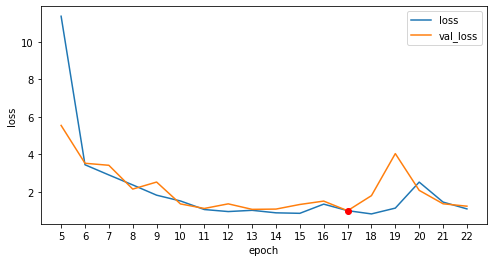

In [17]:
model = get_model()
history = model.fit(
    x_train,
    y_train,
    batch_size=256,
    epochs=30,
    verbose=0,
    validation_split=0.5,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],    
)
plot_history(history, metrics_name='loss')

![image-20201109024441079](images/image-20201109024441079.png)

### Save Checkpoints

在训练模型的时候，有时候需要要保存中间的一些结果，采用tf.keras.callbacks.ModelCheckpoint可以很容易做到这一点。下面是创建ModelCheckpoint的一些参数。

| Arguments         | 描述                                                         |
| :---------------- | ------------------------------------------------------------ |
| filepath          | 模型保存的文件路径。可以添加一些变量，比如：`weights.{epoch:02d}-{val_loss:.2f}.hdf5` |
| monitor           | 监控的metrics，仅当`save_best_only=True`时发挥作用。默认是val_loss。 |
| verbose           | verbosity mode, 0 or 1.                                      |
| save_best_only    | 如果`save_best_only=True`, 仅仅当monitor的metrics获得最佳性能后才会保存模型 |
| mode              | 根据monitor的metrics的最优来决定是否保存模型。仅当`save_best_only=True`时发挥作用，有三个值：auto, min, max。默认为auto。 |
| save_weights_only | 是否仅仅保存模型weights，默认False                           |
| save_freq         | 保存的频次，可以设置`'epoch'`或者 integer. 当设置 `'epoch'`,则每个epoch都会保存模型。当设置为整数，表示每训练`save_freq`个batch，模型会保存一次。 默认是`'epoch'`。 |

需要注意的有两点：

- 当`save_best_only=True`时，避免设置`save_freq`的值，这是因为monitor监控的一般是val_loss, val_accuaracy等，它们是validation数据集上的metrics，`save_freq`会在on_train_batch_end实现触发模型保存的动作，但这个事件里，logs参数并没有validation数据集上的metrics。

- 在版本Tensor Flow 2.3.1中，在ModelCheckpoint的filepath参数中，不支持batch作为参数，这应该是个bug，因为这样的需求很常见。在早期的2.0.0版本中，反而支持，让人困惑。

下面来看具体代码实现，首先安装所需要的包。

In [18]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


然后创建callback，它将在每个epoch保存一次模型参数，代码如下。

In [73]:
import shutil

checkpoint_dir = "./checkpoints"
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)
os.makedirs(checkpoint_dir)

checkpoint_path = os.path.join(checkpoint_dir, "weights.{epoch:02d}-{val_loss:.2f}.h5")
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model = get_model()
model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=5,
    validation_split=0.5,
    callbacks=[cp_callback])

pprint(os.listdir(checkpoint_dir))

Epoch 1/5
1/8 [==>...........................] - ETA: 0s - loss: 2.4357 - accuracy: 0.1250
Epoch 00001: saving model to ./checkpoints/weights.01-20.73.h5
8/8 [==============================] - 0s 22ms/step - loss: 2871.6755 - accuracy: 0.2207 - val_loss: 20.7311 - val_accuracy: 0.3105
Epoch 2/5
1/8 [==>...........................] - ETA: 0s - loss: 21.2779 - accuracy: 0.3750
Epoch 00002: saving model to ./checkpoints/weights.02-5.44.h5
8/8 [==============================] - 0s 6ms/step - loss: 8.6661 - accuracy: 0.3203 - val_loss: 5.4362 - val_accuracy: 0.3906
Epoch 3/5
1/8 [==>...........................] - ETA: 0s - loss: 3.9809 - accuracy: 0.3906
Epoch 00003: saving model to ./checkpoints/weights.03-6.05.h5
8/8 [==============================] - 0s 6ms/step - loss: 3.9042 - accuracy: 0.3145 - val_loss: 6.0466 - val_accuracy: 0.3203
Epoch 4/5
1/8 [==>...........................] - ETA: 0s - loss: 5.3774 - accuracy: 0.2344
Epoch 00004: saving model to ./checkpoints/weights.04-3.34.h5


![image-20201111174325438](images/image-20201111174325438.png)

上面生成了5个[HDF5](https://zhuanlan.zhihu.com/p/104145585)格式的参数文件。下面是加载模型参数的代码。

In [20]:
model = get_model()
loss, accuracy = model.evaluate(x_test, y_test, batch_size=256, verbose=0)
print('test loss is {:.3f}, test accuracy is {:.3f}'.format(loss, accuracy))

model.load_weights(os.path.join(checkpoint_dir, os.listdir(checkpoint_dir)[-1]))
loss, accuracy = model.evaluate(x_test, y_test, batch_size=256, verbose=0)
print('test loss is {:.3f}, test accuracy is {:.3f}'.format(loss, accuracy))

test loss is 2.372, test accuracy is 0.094
test loss is 1.517, test accuracy is 0.496


![image-20201111174445703](images/image-20201111174445703.png)

## 参考

- [Writing your own callbacks](https://www.tensorflow.org/guide/keras/custom_callback)
- [Additional callbacks](https://nbviewer.jupyter.org/github/xuxiangwen/xuxiangwen.github.io/blob/master/_notes/05-ai/54-tensorflow/tutorial/additional_callbacks.ipynb)
- [Save and load models](https://www.tensorflow.org/tutorials/keras/save_and_load)

## 历史

- 2020-11-09：初始 版本
- 2020-11-10：增加Save Checkpoints

In [25]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=1e-5, 
                                                 patience=3, verbose=True) 
    
model = get_model()
model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=15,
    validation_split=0.5,
    callbacks=[reduce_lr])

Epoch 1/15
8/8 [==============================] - 0s 21ms/step - loss: 160.3456 - accuracy: 0.2109 - val_loss: 4.2003 - val_accuracy: 0.4238
Epoch 2/15
8/8 [==============================] - 0s 6ms/step - loss: 2.3418 - accuracy: 0.4355 - val_loss: 1.6185 - val_accuracy: 0.4629
Epoch 3/15
8/8 [==============================] - 0s 5ms/step - loss: 1.5762 - accuracy: 0.4453 - val_loss: 1.4528 - val_accuracy: 0.4590
Epoch 4/15
8/8 [==============================] - 0s 5ms/step - loss: 1.5315 - accuracy: 0.4297 - val_loss: 1.3233 - val_accuracy: 0.5176
Epoch 5/15
8/8 [==============================] - 0s 5ms/step - loss: 1.8130 - accuracy: 0.3965 - val_loss: 2.1257 - val_accuracy: 0.4434
Epoch 6/15
8/8 [==============================] - 0s 5ms/step - loss: 2.2209 - accuracy: 0.4121 - val_loss: 2.0719 - val_accuracy: 0.4023
Epoch 7/15
1/8 [==>...........................] - ETA: 0s - loss: 1.4605 - accuracy: 0.4688
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.

In [155]:
def lr_schedule(epoch, lr):
    lr_times = [(0, 1.0), (5, 1e-1), (10, 1e-2)]
    
    base_lr = 1e-1
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % (epoch + 1, new_lr, lr))
    return new_lr

learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=False)

model = get_model()
model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=15,
    validation_split=0.5,
    callbacks=[learning_rate_scheduler])

Epoch 1/15
8/8 [==============================] - 0s 22ms/step - loss: 279.7803 - accuracy: 0.2363 - val_loss: 14.3825 - val_accuracy: 0.4668
Epoch 2/15
8/8 [==============================] - 0s 5ms/step - loss: 7.2464 - accuracy: 0.5059 - val_loss: 2.0011 - val_accuracy: 0.6230
Epoch 3/15
8/8 [==============================] - 0s 5ms/step - loss: 1.6149 - accuracy: 0.5801 - val_loss: 8.6136 - val_accuracy: 0.3359
Epoch 4/15
8/8 [==============================] - 0s 5ms/step - loss: 3.6705 - accuracy: 0.5293 - val_loss: 1.3637 - val_accuracy: 0.6094
Epoch 5/15
8/8 [==============================] - 0s 5ms/step - loss: 1.2523 - accuracy: 0.5781 - val_loss: 1.6235 - val_accuracy: 0.5703
Epoch 00006: LearningRateScheduler reducing learning rate to 0.010000000000000002 from 0.10000000149011612.
Epoch 6/15
8/8 [==============================] - 0s 5ms/step - loss: 1.2256 - accuracy: 0.6211 - val_loss: 0.9330 - val_accuracy: 0.6621
Epoch 7/15
8/8 [==============================] - 0s 5ms/ste

In [160]:
def lr_schedule(epoch, lr):
    lr_times = [(0, 1.0), (5, 1e-1), (10, 1e-2)]
    
    base_lr = 1e-1
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        # 如果lr比new_lr小，但是又大于0.1倍的new_lr，继续使用lr
        if lr < new_lr and lr > 0.1*new_lr-(1e-7):
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-7, 
                                                 patience=2, verbose=True) 
    
model = get_model()
model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=15,
    validation_split=0.5,
    callbacks=[reduce_lr, learning_rate_scheduler])

Epoch 1/15
8/8 [==============================] - 0s 21ms/step - loss: 219.7346 - accuracy: 0.1699 - val_loss: 54.3401 - val_accuracy: 0.3281
Epoch 2/15
8/8 [==============================] - 0s 6ms/step - loss: 16.6931 - accuracy: 0.4707 - val_loss: 2.3640 - val_accuracy: 0.5820
Epoch 3/15
8/8 [==============================] - 0s 6ms/step - loss: 1.7357 - accuracy: 0.5195 - val_loss: 1.4159 - val_accuracy: 0.5977
Epoch 4/15
8/8 [==============================] - 0s 6ms/step - loss: 1.4353 - accuracy: 0.5254 - val_loss: 1.2305 - val_accuracy: 0.6230
Epoch 5/15
8/8 [==============================] - 0s 6ms/step - loss: 1.1956 - accuracy: 0.5703 - val_loss: 1.1906 - val_accuracy: 0.6309
Epoch 00006: LearningRateScheduler reducing learning rate to 0.01 from 0.1.
Epoch 6/15
8/8 [==============================] - 0s 5ms/step - loss: 1.0025 - accuracy: 0.6191 - val_loss: 1.0433 - val_accuracy: 0.6562
Epoch 7/15
8/8 [==============================] - 0s 5ms/step - loss: 0.9112 - accuracy: 0.

In [ ]:
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(self.lr_schedule, verbose=False)